In [63]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int
import salem
import scipy.stats
import h5py

#pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

ModuleNotFoundError: No module named 'u_interpolate'

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [245]:
lstcoarse = xr.open_mfdataset('/home/ck/DIR/cornkle/data/OBS/MSG_LSTA/lsta_netcdf_1330/lsta_daily_20100826.nc', concat_dim='time')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets ar

In [246]:
msg_folder = cnst.TOPO_1MIN
topo = xr.open_dataarray(msg_folder)
topo = topo.sel(lon=slice(-18,15), lat=slice(4,19))
topo = lstcoarse.salem.transform(topo)

In [247]:
lst_test = xr.open_dataarray('/home/ck/DIR/cornkle/data/NFLICS/lsta_topo_test/LSASAF_lst_anom_Daymean_withmask_withHistClim_20200623.nc')

In [248]:
lst_test

<xarray.DataArray 'lst_anom_dailymean' (phony_dim_0: 714, phony_dim_1: 1436)>
[1025304 values with dtype=float64]
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    MISSING_VALUE:  9.969209968386869e+36
    FillValue:      -99999
    units:          Degrees Celcius

In [249]:
ltest = xr.open_dataset('/home/ck/DIR/cornkle/data/NFLICS/LSTA_coords/SEVIRILST_WA_geoloc.nc')

In [250]:
ltest

<xarray.Dataset>
Dimensions:        (COLUMN: 3712, ROW: 3712, WA_COLUMN: 1436, WA_ROW: 714)
Coordinates:
  * COLUMN         (COLUMN) int64 0 1 2 3 4 5 ... 3706 3707 3708 3709 3710 3711
  * ROW            (ROW) int64 0 1 2 3 4 5 6 ... 3706 3707 3708 3709 3710 3711
  * WA_COLUMN      (WA_COLUMN) int64 0 1 2 3 4 5 ... 1431 1432 1433 1434 1435
  * WA_ROW         (WA_ROW) int64 0 1 2 3 4 5 6 ... 707 708 709 710 711 712 713
Data variables:
    full_grid_lon  (ROW, COLUMN) float64 ...
    full_grid_lat  (ROW, COLUMN) float64 ...
    WA_lon         (WA_ROW, WA_COLUMN) float64 ...
    WA_lat         (WA_ROW, WA_COLUMN) float64 ...
Attributes:
    lat_source:  hdf5_lsasaf_msg_lat_msg-disk_4bytesprecision
    lon_source:  hdf5_lsasaf_msg_lon_msg-disk_4bytesprecision
    creation:    26/02/2020

In [251]:
lons, lats = np.meshgrid(topo['lon'].values,topo['lat'].values)

In [252]:
lst = u_int.griddata_int(lst_test.values, ltest['WA_lon'].values, ltest['WA_lat'].values, lons, lats, isll=True, method='linear')#regrid_irregular_quick(ltest['WA_lon'].values, ltest['WA_lat'].values, lons, lats, lst_test.values)

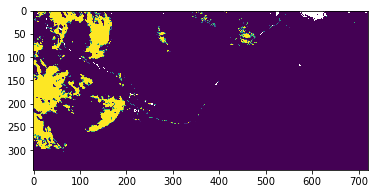

In [257]:
plt.imshow(lst)

In [258]:
lst_good = xr.DataArray(lst, coords={'lon': topo['lon'], 'lat': topo['lat']}, dims=['lat', 'lon'])

In [259]:
lst_good = lst_good.where(lst_good.values<100)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


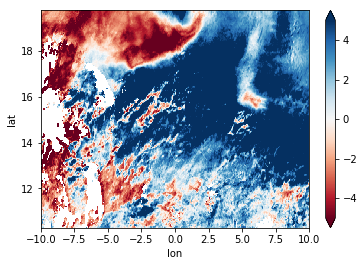

In [260]:
lst_good.plot(vmin=-5, vmax=5, cmap='RdBu')

In [354]:
box = [-10,-1,12,17]
top = topo.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
ls = lst_good.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

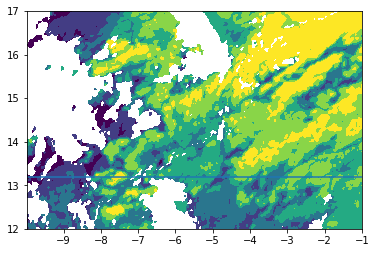

In [422]:
plt.contourf(ls.lon, ls.lat, ls, vmin=-7, vmax=7)
plt.axhline(13.2)

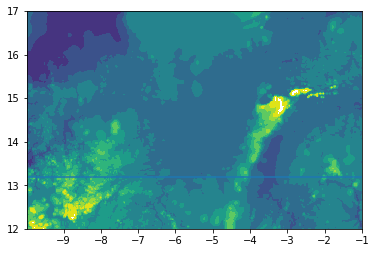

In [423]:
plt.contourf(top.lon, top.lat, top, levels=[100,150,200,250,300,350,400,450,500,550,600])
plt.axhline(13.2)

In [449]:
box = [-5,-1,13.7,13.75]
topo_small = top.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
ls_small = lst_good.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

In [450]:
lst_plt = ls_small.mean('lat')
topo_plt = topo_small.mean('lat')

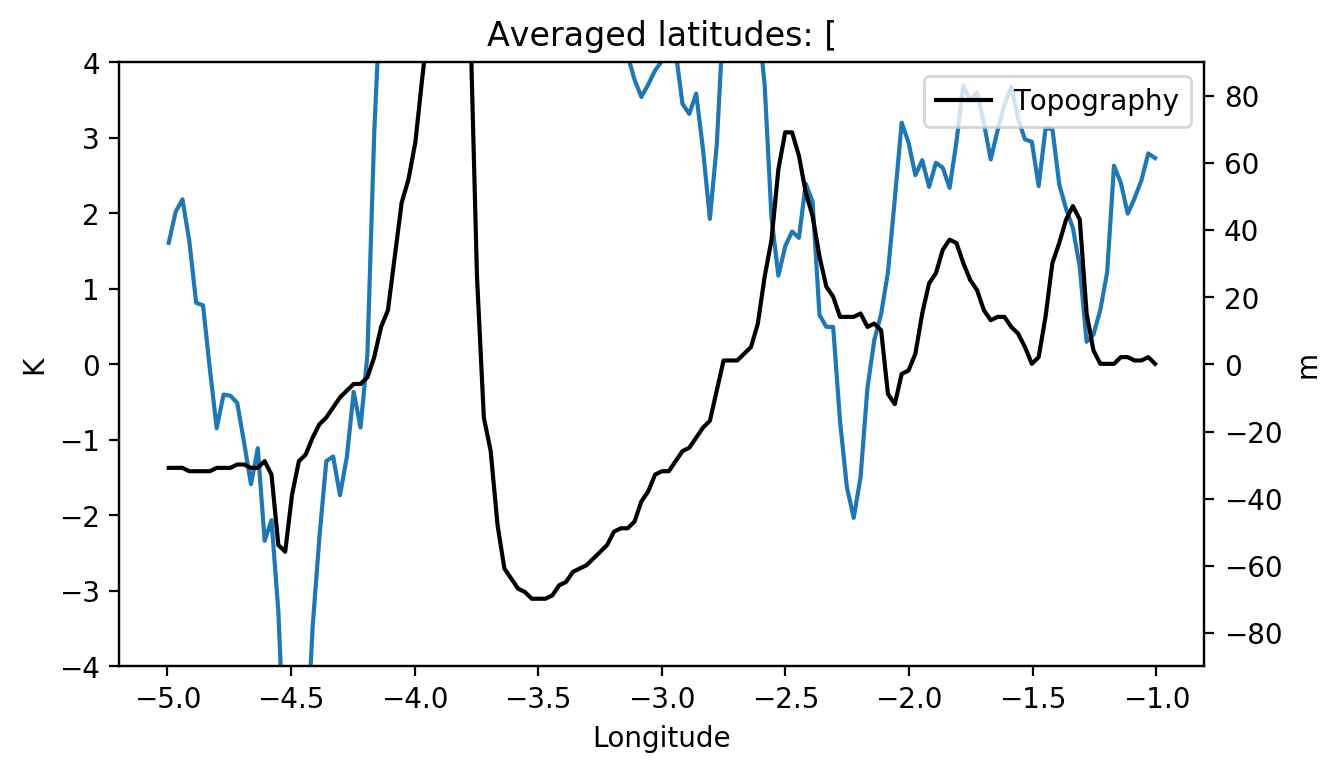

In [451]:
f=plt.figure(figsize=(7,4), dpi=200)
ax = f.add_subplot(111)
ax1 = ax.twinx()
ax.plot(lst_plt.lon, lst_plt, label='LSTA')
ax.set_ylim(-4,4)
ax1.plot(topo_plt.lon, topo_plt-np.mean(topo_plt), 'k', label='Topography')
ax1.set_ylim(-90,90)
ax.set_ylabel('K')
ax1.set_ylabel('m')
ax.set_xlabel('Longitude')
plt.title('Averaged latitudes: [')
plt.legend()

In [215]:
cores = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/cores_fromMeteosat/cores/coresPower_MSG_-40_700km2_-50points_dominant_2010_08.nc' )

In [234]:
# lst = xr.open_mfdataset('/home/ck/DIR/cornkle/data/NFLICS/LSTA/netcdf/HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_201006*.nc', concat_dim='time')
lst = xr.open_mfdataset('/home/ck/DIR/cornkle/data/OBS/MSG_LSTA/lsta_netcdf_1330/lsta_daily_201008*.nc', concat_dim='time')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combi

In [11]:
lst_crop = lst['LSTA'].sel(lon=slice(-5,0), lat=slice(13.5,13.8)).mean('time')   #slice(-2.5,-1), lat=slice(14,14.3)

In [146]:
cores = cores['blobs'].sel(lon=slice(-2.5,-1), lat=slice(14,14.3))

In [147]:
cores = cores.where(cores.values>0.5).count(['time'])

In [235]:
topo = lst_crop.salem.transform(topo)

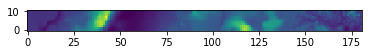

In [13]:
plt.imshow(topo, origin='lower')

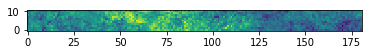

In [14]:
plt.imshow(lst_crop, origin='lower')

In [15]:
scipy.stats.pearsonr(topo.values.flatten(), lst_crop.values.flatten())

(-0.07586735539228717, 0.0007040263687637137)

In [16]:
lst_plt = lst_crop.mean('lat')
topo_plt = topo.mean('lat')
# cores_plt = cores.sum('lat')